In [8]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_43383/1184199116.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [4]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data


In [10]:
del Y

In [6]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_43383/1949801412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt

In [ ]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



In [21]:
# Load references (signatures only, no healthy)
refs = torch.load('reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_var_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_43383/786988288.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('reference_trajectories.pt')

Lambda kernel condition number: 1104249.00
Phi kernel condition number: 330509.75

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-18.4207, -18.4207, -17.3858, -16.3508, -16.3508])
Base value centered (first 5): tensor([-0.5458, -0.5458,  0.4891,  1.5240,  1.5240])
Base value centered mean: 3.23352810482902e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0101,  0.0173,  0.0224, -0.0156])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 

In [22]:
print(model.K_total)
print(model.K)

21
20


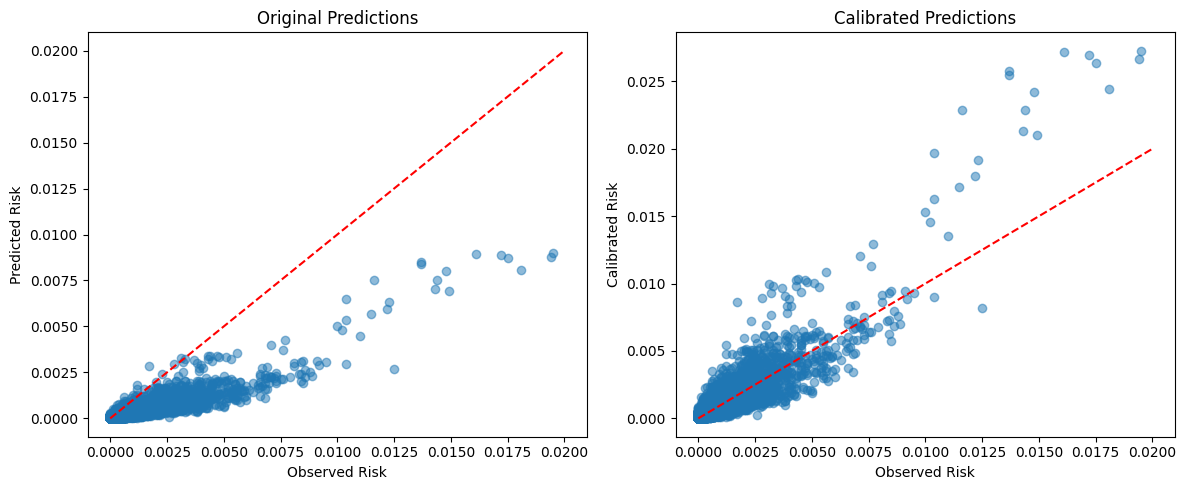

Mean observed risk: 0.000438
Mean predicted risk (original): 0.000144
Mean predicted risk (calibrated): 0.000438
Calibration scale factor: 3.032
R^2: 0.704


In [23]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

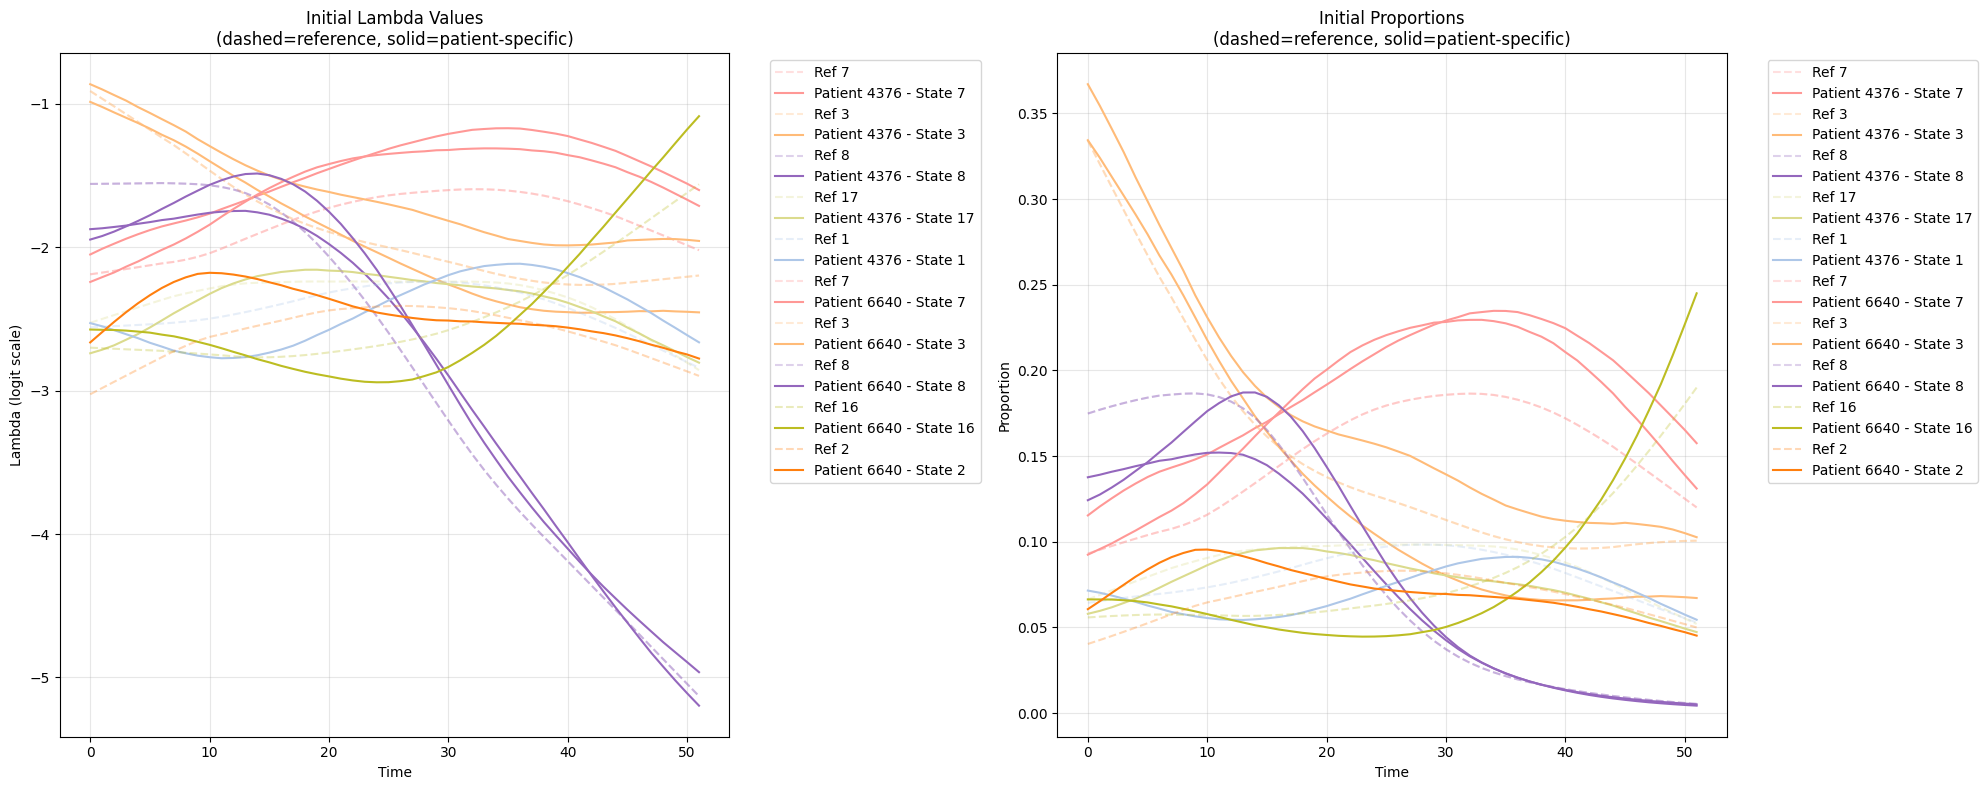


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.139
Range of shifts: [-0.131, 0.461]

Top states and average proportions:
State 7: 0.188
State 3: 0.137
State 8: 0.077
State 17: 0.077
State 1: 0.071

Patient 6640:
Mean shift: 0.040
Std of shifts: 0.079
Range of shifts: [-0.164, 0.232]

Top states and average proportions:
State 7: 0.178
State 3: 0.175
State 8: 0.087
State 16: 0.081
State 2: 0.072


In [24]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Initial Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Initial Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

/Users/sarahurbut/aladynoulli2/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:883: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


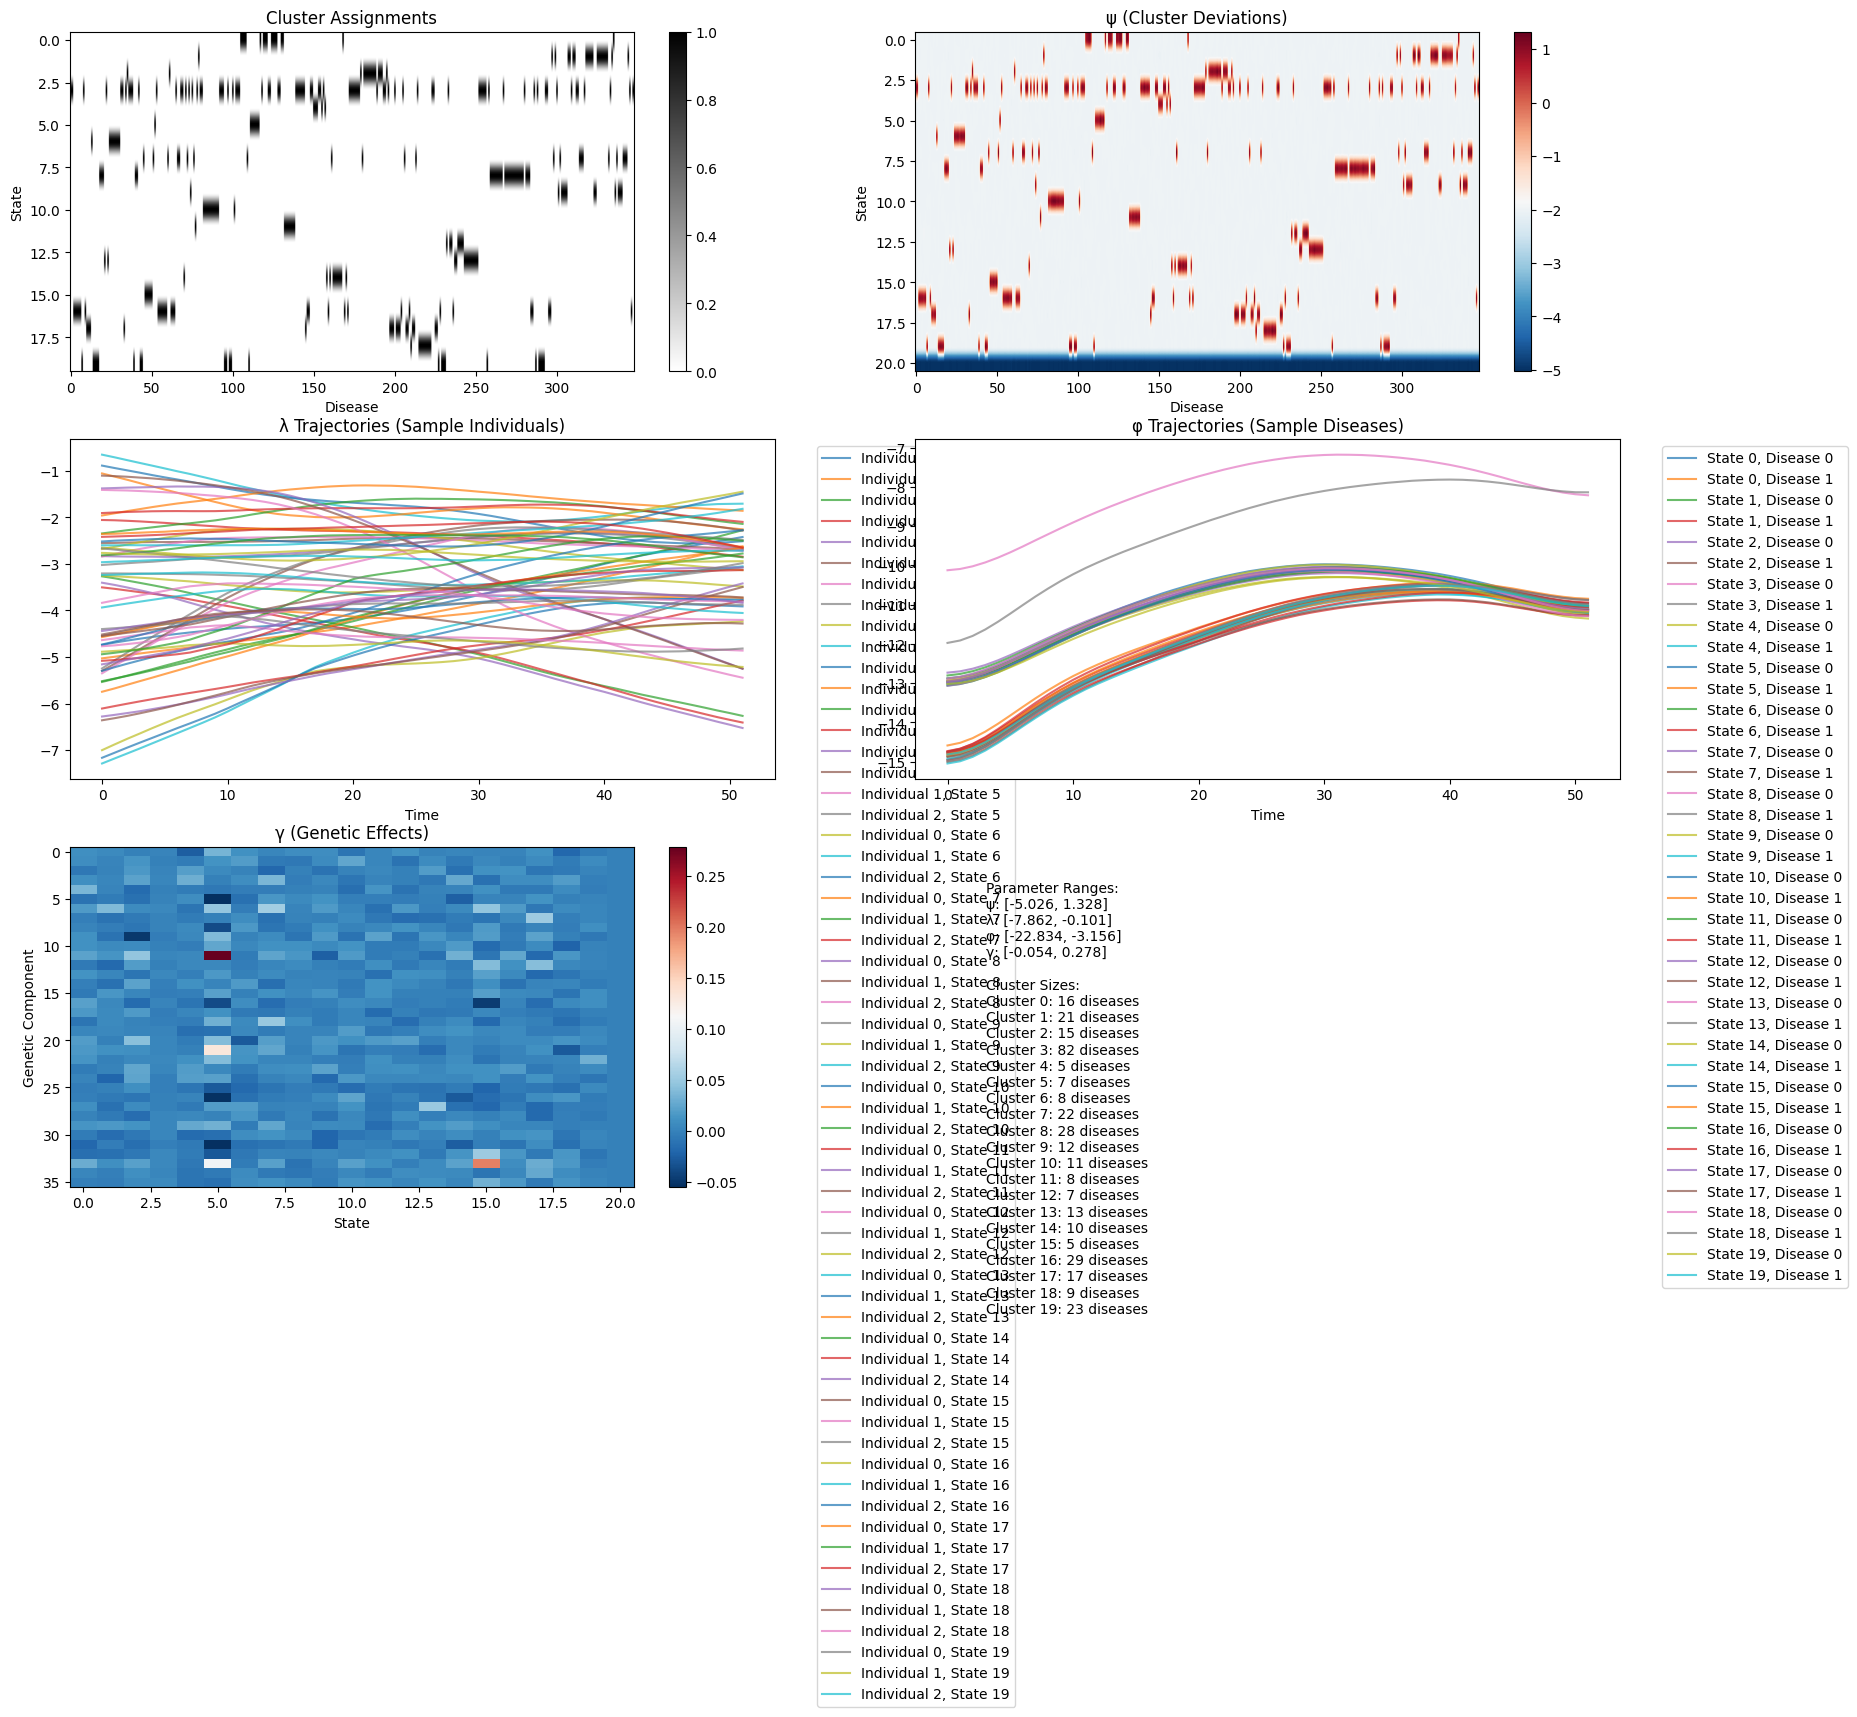

In [25]:
model.visualize_initialization()

In [26]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()


In [27]:
import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_100k, num_epochs=20, learning_rate=1e-2, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

Starting training...


/Users/sarahurbut/aladynoulli2/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 76.6575

Epoch 1
Loss: 936.4244

Estimated total training time: 10.4 minutes

Epoch 2
Loss: 128.3876

Epoch 3
Loss: 256.3195

Epoch 4
Loss: 557.6423

Epoch 5
Loss: 411.4573

Epoch 6
Loss: 146.2966

Epoch 7
Loss: 77.9566

Epoch 8
Loss: 208.9390

Epoch 9
Loss: 313.2033

Epoch 10
Loss: 265.0834

Epoch 11
Loss: 142.0387

Epoch 12
Loss: 74.1644

Epoch 13
Loss: 107.1597

Epoch 14
Loss: 176.4070

Epoch 15
Loss: 195.2598

Epoch 16
Loss: 149.0591

Epoch 17
Loss: 91.0964

Epoch 18
Loss: 74.8438

Epoch 19
Loss: 102.7239
         9246055 function calls (9245855 primitive calls) in 658.989 seconds

   Ordered by: cumulative time
   List reduced from 168 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000  658.989  329.495 /opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3514(run_code)
        2    0.000    0.000  658.989  329.495 {built-in method builtins.exec

In [17]:

history_new = model.fit(E_100k, num_epochs=100, learning_rate=1e-2, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli2/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Data loss: 65.6999
GP loss: 10.9249

Epoch 0
Loss: 76.6247
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Data loss: 65.6999
GP loss: 6.4003

Estimated total training time: 53.7 minutes
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Data loss: 65.6999
GP loss: 4.8698
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Data loss: 65.6999
GP loss: 5.0193
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Data loss: 65.6999
GP loss: 5.1913
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Data loss: 65.6998
GP loss: 4.6912
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348

KeyboardInterrupt: 

In [ ]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-4:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

In [ ]:
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

In [ ]:

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history_new['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history_new['max_grad_lambda'], label='Lambda')
ax2.plot(history_new['max_grad_phi'], label='Phi')
ax2.plot(history_new['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [125]:
model_save_path='/Users/sarahurbut/Dropbox (Personal)/model_with_poptrajectory_lr1e-4_grad.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': essentials['disease_names'],
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)



In [24]:
# Get μ_dt from checkpoint and predictions
mu_dt = model.prevalence_t  # Shape: (348, 52)



In [ ]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [ ]:
# Get predictions
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
predicted_risk_2d = pi_pred.cpu().detach().numpy().mean(axis=0)  # average across individuals

# Get raw observations and calculate scale factor
Y_np = model.Y.cpu().detach().numpy()
Y_mean_2d = Y_np.mean(axis=0)  # average across individuals
scale_factor = Y_mean_2d.mean() / predicted_risk_2d.mean()
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs raw observations
ax1.scatter(Y_mean_2d.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Observed Event Rate (Y)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Observed Events')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs raw observations
ax2.scatter(Y_mean_2d.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Observed Event Rate (Y)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Observed Events')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Scale factor: {scale_factor:.3f}")

In [ ]:
# Get predictions
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
predicted_risk_2d = pi_pred.cpu().detach().numpy().mean(axis=0)  # average across individuals

# Calculate scale factor using means
# Convert mu_dt to numpy and calculate scale factor
mu_dt_np = mu_dt.cpu().detach().numpy()
scale_factor = mu_dt_np.mean() / predicted_risk_2d.mean()
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Scale factor: {scale_factor:.3f}")

In [ ]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

In [ ]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])

In [ ]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])

In [ ]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Final Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [ ]:
import torch
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/ptdir/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/ptdir/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/ptdir/initial_clusters_400k.pt')
# Load the saved model and data
model_path = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/results_ref_traj/output_390000_400000/model.pt'
checkpoint = torch.load(model_path)


In [ ]:
checkpoint['hyperparameters']

In [ ]:

# Create model instance with saved parameters
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=checkpoint['hyperparameters']['N'],
    D=checkpoint['hyperparameters']['D'],
    T=checkpoint['hyperparameters']['T'],
    K=20,
    P=checkpoint['hyperparameters']['P'],
    init_var_scaler=1e-1,
    G=checkpoint['G'],
    Y=checkpoint['Y'],
    genetic_scale=3,
    prevalence_t=checkpoint['prevalence_t'],
    signature_references=signature_refs,
    healthy_reference=True,
    disease_names=checkpoint['disease_names']
)

# Load the state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.clusters=checkpoint['clusters']
model.eval()  # Set to evaluation mode

# Get predictions
with torch.no_grad():
    predicted = model.forward()
    if isinstance(predicted, tuple):
        pi_pred = predicted[0]
    else:
        pi_pred = predicted

# Get actual values
Y = checkpoint['Y']

# Convert to numpy for calibration
if isinstance(Y, torch.Tensor):
    Y = Y.cpu().detach().numpy()
if isinstance(pi_pred, torch.Tensor):
    pi_pred = pi_pred.cpu().detach().numpy()

# Calculate marginal risks
observed_risk = Y.mean(axis=0).flatten()
predicted_risk = pi_pred.mean(axis=0).flatten()


In [ ]:
# Check if they match
print("Checkpoint clusters shape:", checkpoint['clusters'].shape)
print("Initial clusters shape:", initial_clusters.shape)
print("Model clusters shape:", model.clusters.shape)

# Load state dict and check again
model.load_state_dict(checkpoint['model_state_dict'])
print("\nAfter loading state dict:")
print("Model clusters now:", model.clusters)
# Should now match checkpoint['clusters']


In [95]:
mu_dt = checkpoint['prevalence_t']  # Shape: (348, 52)

# Flatten it to match the prediction format
mu_dt_flat = mu_dt.flatten()  # Will be (348*52,)


In [ ]:
mu_dt_flat.shape

In [ ]:

# Create visualization
def plot_calibration_results(observed_risk, predicted_risk, frac=0.3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Original predictions
    ax1.scatter(observed_risk, predicted_risk, alpha=0.5, s=20)
    ax1.plot([0, max(observed_risk)], [0, max(observed_risk)], 'r--', label='Perfect calibration')
    ax1.set_title('Original Predictions')
    ax1.set_xlabel('Observed Risk')
    ax1.set_ylabel('Predicted Risk')
    
    # Apply LOESS calibration
    calibrated_risk = lowess(
        observed_risk,
        predicted_risk,
        frac=frac,
        return_sorted=False
    )
    
    # Calibrated predictions
    ax2.scatter(observed_risk, calibrated_risk, alpha=0.5, s=20)
    ax2.plot([0, max(observed_risk)], [0, max(observed_risk)], 'r--', label='Perfect calibration')
    ax2.set_title('LOESS Calibrated')
    ax2.set_xlabel('Observed Risk')
    ax2.set_ylabel('Calibrated Risk')
    
    # LOESS calibration curve
    sort_idx = np.argsort(predicted_risk)
    pred_sorted = predicted_risk[sort_idx]
    obs_sorted = observed_risk[sort_idx]
    smoothed = lowess(obs_sorted, pred_sorted, frac=frac)
    
    ax3.scatter(predicted_risk, observed_risk, alpha=0.3, s=20, label='Data points')
    ax3.plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=2, label='LOESS curve')
    ax3.plot([0, max(predicted_risk)], [0, max(predicted_risk)], 'k--', label='Perfect calibration')
    ax3.set_xlabel('Predicted Risk')
    ax3.set_ylabel('Observed Risk')
    ax3.set_title('Calibration Curve')
    ax3.legend()
    
    plt.tight_layout()
    
    # Print performance metrics
    print("\nPerformance Metrics:")
    print(f"Original R²: {r2_score(observed_risk, predicted_risk):.3f}")
    print(f"LOESS Calibrated R²: {r2_score(observed_risk, calibrated_risk):.3f}")
    print(f"Original RMSE: {np.sqrt(mean_squared_error(observed_risk, predicted_risk)):.6f}")
    print(f"LOESS Calibrated RMSE: {np.sqrt(mean_squared_error(observed_risk, calibrated_risk)):.6f}")
    
    return calibrated_risk, smoothed

# Run the analysis
calibrated_risk, smoothed = plot_calibration_results(mu_dt_flat, predicted_risk, frac=0.3)

# Save calibration results
calibration_results = {
    'original_predictions': predicted_risk,
    'calibrated_predictions': calibrated_risk,
    'loess_curve': smoothed,
    'observed_risk': observed_risk
}

torch.save(calibration_results, '/Users/sarahurbut/Dropbox (Personal)/calibration_results.pt')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate both calibration methods
# Simple scaling
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
scaled_risk = predicted_risk * scale_factor

# LOESS calibration
loess_risk = lowess(observed_risk, predicted_risk, frac=0.3, return_sorted=False)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original predictions
ax1.scatter(observed_risk, predicted_risk, alpha=0.5, s=20)
ax1.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax1.set_title('Original Predictions')
ax1.set_xlabel('Observed Risk')
ax1.set_ylabel('Predicted Risk')
ax1.legend()

# Simple scaling calibration
ax2.scatter(observed_risk, scaled_risk, alpha=0.5, s=20)
ax2.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f})')
ax2.set_xlabel('Observed Risk')
ax2.set_ylabel('Scaled Risk')
ax2.legend()

# LOESS calibration
ax3.scatter(observed_risk, loess_risk, alpha=0.5, s=20)
ax3.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax3.set_title('LOESS Calibration')
ax3.set_xlabel('Observed Risk')
ax3.set_ylabel('LOESS Calibrated Risk')
ax3.legend()

# Calibration curves comparison
sort_idx = np.argsort(predicted_risk)
pred_sorted = predicted_risk[sort_idx]
obs_sorted = observed_risk[sort_idx]
smoothed = lowess(obs_sorted, pred_sorted, frac=0.3)

ax4.scatter(predicted_risk, observed_risk, alpha=0.3, s=20, label='Data points')
ax4.plot(pred_sorted, pred_sorted * scale_factor, 'g-', label='Simple scaling', linewidth=2)
ax4.plot(smoothed[:, 0], smoothed[:, 1], 'r-', label='LOESS curve', linewidth=2)
ax4.plot([0, max(predicted_risk)], [0, max(predicted_risk)], 'k--', label='x=y line')
ax4.set_title('Calibration Curves Comparison')
ax4.set_xlabel('Predicted Risk')
ax4.set_ylabel('Observed Risk')
ax4.legend()

plt.tight_layout()
plt.show()

# Print performance metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nPerformance Metrics:")
print(f"Original R²: {r2_score(observed_risk, predicted_risk):.3f}")
print(f"Simple Scaling R²: {r2_score(observed_risk, scaled_risk):.3f}")
print(f"LOESS Calibrated R²: {r2_score(observed_risk, loess_risk):.3f}")
print(f"\nOriginal RMSE: {np.sqrt(mean_squared_error(observed_risk, predicted_risk)):.6f}")
print(f"Simple Scaling RMSE: {np.sqrt(mean_squared_error(observed_risk, scaled_risk)):.6f}")
print(f"LOESS Calibrated RMSE: {np.sqrt(mean_squared_error(observed_risk, loess_risk)):.6f}")

In [ ]:
# Get μ_dt from checkpoint and predictions
mu_dt = checkpoint['prevalence_t']  # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate various error metrics including prevalence-adjusted ones
disease_metrics = []
for d in range(D):
    disease_mask = np.arange(d*T, (d+1)*T)
    
    # Get values for this disease
    obs = observed_risk[disease_mask]
    pred = predicted_risk[disease_mask]
    loess_pred = loess_risk[disease_mask]
    
    # Calculate mean prevalence
    mean_prev = np.mean(obs)
    
    # Calculate various metrics
    metrics = {
        'disease': disease_names[d],
        'mean_prevalence': mean_prev,
        'rmse_original': np.sqrt(mean_squared_error(obs, pred)),
        'rmse_loess': np.sqrt(mean_squared_error(obs, loess_pred)),
        # Relative RMSE (normalized by prevalence)
        'relative_rmse': np.sqrt(mean_squared_error(obs, pred)) / mean_prev if mean_prev > 0 else np.inf,
        # Mean Absolute Percentage Error
        'mape': np.mean(np.abs((obs - pred) / obs)) if mean_prev > 0 else np.inf,
        # Coefficient of Variation of RMSE
        'cv_rmse': np.sqrt(mean_squared_error(obs, pred)) / mean_prev if mean_prev > 0 else np.inf,
        # R² across timepoints
        'r2_original': r2_score(obs, pred),
        'r2_loess': r2_score(obs, loess_pred)
    }
    disease_metrics.append(metrics)

# Convert to DataFrame
metrics_df = pd.DataFrame(disease_metrics)

# Sort by different metrics
print("\nWorst calibrated diseases by absolute RMSE:")
print(metrics_df.sort_values('rmse_original', ascending=False)[['disease', 'mean_prevalence', 'rmse_original', 'relative_rmse']].head())

print("\nWorst calibrated diseases by relative RMSE (normalized by prevalence):")
print(metrics_df[metrics_df['mean_prevalence'] > 0.0001]  # Filter out very rare diseases
      .sort_values('relative_rmse', ascending=False)[['disease', 'mean_prevalence', 'rmse_original', 'relative_rmse']].head())

# Visualize relationship between prevalence and errors
plt.figure(figsize=(15, 5))

# Absolute RMSE vs Prevalence
plt.subplot(131)
plt.scatter(metrics_df['mean_prevalence'], 
           metrics_df['rmse_original'], 
           alpha=0.6)
plt.xlabel('Mean Prevalence')
plt.ylabel('Absolute RMSE')
plt.title('RMSE vs Prevalence')
plt.xscale('log')
plt.yscale('log')

# Relative RMSE vs Prevalence
plt.subplot(132)
plt.scatter(metrics_df['mean_prevalence'], 
           metrics_df['relative_rmse'], 
           alpha=0.6)
plt.xlabel('Mean Prevalence')
plt.ylabel('Relative RMSE')
plt.title('Relative RMSE vs Prevalence')
plt.xscale('log')
plt.yscale('log')

# Improvement from LOESS vs Prevalence
plt.subplot(133)
improvement = (metrics_df['rmse_original'] - metrics_df['rmse_loess']) / metrics_df['rmse_original'] * 100
plt.scatter(metrics_df['mean_prevalence'], 
           improvement, 
           alpha=0.6)
plt.xlabel('Mean Prevalence')
plt.ylabel('% Improvement from LOESS')
plt.title('LOESS Improvement vs Prevalence')
plt.xscale('log')

plt.tight_layout()
plt.show()

# Print summary of worst cases after prevalence adjustment
print("\nWorst calibrated common diseases (prevalence > 1%):")
print(metrics_df[metrics_df['mean_prevalence'] > 0.01]
      .sort_values('relative_rmse', ascending=False)
      [['disease', 'mean_prevalence', 'rmse_original', 'relative_rmse']]
      .head())

print("\nWorst calibrated rare diseases (prevalence < 1%):")
print(metrics_df[(metrics_df['mean_prevalence'] < 0.01) & (metrics_df['mean_prevalence'] > 0.0001)]
      .sort_values('relative_rmse', ascending=False)
      [['disease', 'mean_prevalence', 'rmse_original', 'relative_rmse']]
      .head())


import matplotlib.pyplot as plt
import numpy as np

def plot_worst_best_cases(metrics_df, observed_risk, predicted_risk, loess_risk, D, T, n_cases=3):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    
    # Get worst and best cases by relative RMSE (for diseases with meaningful prevalence)
    min_prevalence = 0.0001  # Threshold for meaningful prevalence
    filtered_df = metrics_df[metrics_df['mean_prevalence'] > min_prevalence]
    worst_cases = filtered_df.nlargest(n_cases, 'relative_rmse')
    best_cases = filtered_df.nsmallest(n_cases, 'relative_rmse')
    
    # Plot worst cases
    for idx, (_, case) in enumerate(worst_cases.iterrows()):
        ax = [ax1, ax2, ax3][idx]
        disease_idx = list(metrics_df['disease']).index(case['disease'])
        disease_mask = np.arange(disease_idx*T, (disease_idx+1)*T)
        
        # Original predictions
        ax.scatter(predicted_risk[disease_mask], observed_risk[disease_mask], 
                  alpha=0.6, label='Original', color='blue')
        # LOESS calibrated
        ax.scatter(predicted_risk[disease_mask], loess_risk[disease_mask], 
                  alpha=0.6, label='LOESS', color='red')
        # x=y line
        ax.plot([0, max(predicted_risk[disease_mask])], 
                [0, max(predicted_risk[disease_mask])], 
                'k--', label='x=y')
        
        ax.set_title(f'Worst #{idx+1}: {case["disease"]}\n' + 
                    f'Rel.RMSE: {case["relative_rmse"]:.2f}\n' +
                    f'Prevalence: {case["mean_prevalence"]:.4f}')
        ax.set_xlabel('Predicted Risk')
        ax.set_ylabel('Observed Risk')
        ax.legend()
    
    # Plot best cases
    for idx, (_, case) in enumerate(best_cases.iterrows()):
        ax = [ax4, ax5, ax6][idx]
        disease_idx = list(metrics_df['disease']).index(case['disease'])
        disease_mask = np.arange(disease_idx*T, (disease_idx+1)*T)
        
        # Original predictions
        ax.scatter(predicted_risk[disease_mask], observed_risk[disease_mask], 
                  alpha=0.6, label='Original', color='blue')
        # LOESS calibrated
        ax.scatter(predicted_risk[disease_mask], loess_risk[disease_mask], 
                  alpha=0.6, label='LOESS', color='red')
        # x=y line
        ax.plot([0, max(predicted_risk[disease_mask])], 
                [0, max(predicted_risk[disease_mask])], 
                'k--', label='x=y')
        
        ax.set_title(f'Best #{idx+1}: {case["disease"]}\n' + 
                    f'Rel.RMSE: {case["relative_rmse"]:.2f}\n' +
                    f'Prevalence: {case["mean_prevalence"]:.4f}')
        ax.set_xlabel('Predicted Risk')
        ax.set_ylabel('Observed Risk')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nWorst Calibrated Diseases (with prevalence > 0.0001):")
    print(worst_cases[['disease', 'mean_prevalence', 'rmse_original', 'relative_rmse', 'r2_original']])
    
    print("\nBest Calibrated Diseases (with prevalence > 0.0001):")
    print(best_cases[['disease', 'mean_prevalence', 'rmse_original', 'relative_rmse', 'r2_original']])

# Call the plotting function
plot_worst_best_cases(metrics_df, observed_risk, predicted_risk, loess_risk, D, T)

# Additional temporal pattern visualization for worst cases
def plot_temporal_patterns(metrics_df, observed_risk, predicted_risk, D, T, n_cases=3):
    worst_cases = metrics_df[metrics_df['mean_prevalence'] > 0.0001].nlargest(n_cases, 'relative_rmse')
    
    plt.figure(figsize=(15, 5))
    for idx, (_, case) in enumerate(worst_cases.iterrows()):
        plt.subplot(1, 3, idx+1)
        disease_idx = list(metrics_df['disease']).index(case['disease'])
        disease_mask = np.arange(disease_idx*T, (disease_idx+1)*T)
        
        # Plot temporal pattern
        timepoints = range(T)
        plt.plot(timepoints, observed_risk[disease_mask], 'b-', label='Observed')
        plt.plot(timepoints, predicted_risk[disease_mask], 'r--', label='Predicted')
        
        plt.title(f"{case['disease']}\nTemporal Pattern")
        plt.xlabel('Timepoint')
        plt.ylabel('Risk')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the temporal pattern plotting function
plot_temporal_patterns(metrics_df, observed_risk, predicted_risk, D, T)

In [81]:
# Get the smoothed prevalences (mu_dt) from the model
mu_dt = checkpoint['prevalence_t'] 


In [ ]:
mu_dt.shape

In [ ]:
# Calculate scaling factor using smoothed prevalence
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

def plot_calibration_comparison(metrics_df, mu_dt, predicted_risk_2d, scaled_risk_2d, loess_risk_2d, disease_names, n_cases=3):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    
    # Get worst and best cases
    filtered_df = metrics_df[metrics_df['mean_mu_dt'] > 0.0001]
    worst_cases = filtered_df.nlargest(n_cases, 'relative_rmse')
    best_cases = filtered_df.nsmallest(n_cases, 'relative_rmse')
    
    for idx, (_, case) in enumerate(worst_cases.iterrows()):
        ax = [ax1, ax2, ax3][idx]
        disease_idx = disease_names.index(case['disease'])
        
        # Plot all three versions
        ax.scatter(mu_dt[disease_idx, :], predicted_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Original', color='blue')
        ax.scatter(mu_dt[disease_idx, :], scaled_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Simple Scaling', color='green')
        ax.scatter(mu_dt[disease_idx, :], loess_risk_2d[disease_idx, :], 
                  alpha=0.6, label='LOESS', color='red')
        
        max_val = max(np.max(mu_dt[disease_idx, :]), 
                     np.max(predicted_risk_2d[disease_idx, :]))
        ax.plot([0, max_val], [0, max_val], 'k--', label='x=y')
        
        ax.set_title(f'Worst #{idx+1}: {case["disease"]}\n' + 
                    f'Rel.RMSE: {case["relative_rmse"]:.2f}\n' +
                    f'Mean μ_dt: {case["mean_mu_dt"]:.4f}')
        ax.set_xlabel('Smoothed Prevalence (μ_dt)')
        ax.set_ylabel('Predicted Risk')
        ax.legend()
    
    for idx, (_, case) in enumerate(best_cases.iterrows()):
        ax = [ax4, ax5, ax6][idx]
        disease_idx = disease_names.index(case['disease'])
        
        ax.scatter(mu_dt[disease_idx, :], predicted_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Original', color='blue')
        ax.scatter(mu_dt[disease_idx, :], scaled_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Simple Scaling', color='green')
        ax.scatter(mu_dt[disease_idx, :], loess_risk_2d[disease_idx, :], 
                  alpha=0.6, label='LOESS', color='red')
        
        max_val = max(np.max(mu_dt[disease_idx, :]), 
                     np.max(predicted_risk_2d[disease_idx, :]))
        ax.plot([0, max_val], [0, max_val], 'k--', label='x=y')
        
        ax.set_title(f'Best #{idx+1}: {case["disease"]}\n' + 
                    f'Rel.RMSE: {case["relative_rmse"]:.2f}\n' +
                    f'Mean μ_dt: {case["mean_mu_dt"]:.4f}')
        ax.set_xlabel('Smoothed Prevalence (μ_dt)')
        ax.set_ylabel('Predicted Risk')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Print scaling factor
print(f"Simple scaling factor: {scale_factor:.3f}")

# Calculate metrics for all three versions
metrics_smoothed = []
for d in range(348):
    metrics_smoothed.append({
        'disease': disease_names[d],
        'mean_mu_dt': np.mean(mu_dt[d, :]),
        'rmse_original': np.sqrt(mean_squared_error(mu_dt[d, :], predicted_risk_2d[d, :])),
        'rmse_scaled': np.sqrt(mean_squared_error(mu_dt[d, :], scaled_risk_2d[d, :])),
        'rmse_loess': np.sqrt(mean_squared_error(mu_dt[d, :], loess_risk_2d[d, :])),
        'relative_rmse': np.sqrt(mean_squared_error(mu_dt[d, :], predicted_risk_2d[d, :])) / 
                        np.mean(mu_dt[d, :]) if np.mean(mu_dt[d, :]) > 0 else np.inf
    })

metrics_df_smoothed = pd.DataFrame(metrics_smoothed)

# Generate plots
plot_calibration_comparison(metrics_df_smoothed, mu_dt, predicted_risk_2d, scaled_risk_2d, loess_risk_2d, disease_names)

In [ ]:
# Create one big plot with all points from all diseases
plt.figure(figsize=(12, 8))

# Plot all points
plt.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, label='Original', color='blue', s=10)
plt.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, label='Simple Scaling', color='green', s=10)
plt.scatter(mu_dt.flatten(), loess_risk_2d.flatten(), 
           alpha=0.3, label='LOESS', color='red', s=10)

# Add x=y line
max_val = max(np.max(mu_dt), np.max(predicted_risk_2d))
plt.plot([0, max_val], [0, max_val], 'k--', label='x=y')

plt.xlabel('Smoothed Prevalence (μ_dt)')
plt.ylabel('Predicted Risk')
plt.title('All Diseases - All Timepoints')
plt.legend()

# Optional: log scale if distribution is very skewed
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nOverall metrics:")
print(f"Original RMSE: {np.sqrt(mean_squared_error(mu_dt.flatten(), predicted_risk_2d.flatten())):.6f}")
print(f"Simple Scaling RMSE: {np.sqrt(mean_squared_error(mu_dt.flatten(), scaled_risk_2d.flatten())):.6f}")
print(f"LOESS RMSE: {np.sqrt(mean_squared_error(mu_dt.flatten(), loess_risk_2d.flatten())):.6f}")

In [ ]:
# Calculate calibration using smoothed prevalence (μ_dt) as the target
# 1. Simple scaling
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

# 2. LOESS using smoothed prevalence
loess_risk_new = lowess(
    mu_dt.flatten(),  # using μ_dt as target
    predicted_risk_2d.flatten(),
    frac=0.3,
    return_sorted=False
).reshape(348, 52)

# Plot comparison
plt.figure(figsize=(12, 8))

plt.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, label='Original', color='blue', s=10)
plt.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, label='Simple Scaling', color='green', s=10)
plt.scatter(mu_dt.flatten(), loess_risk_new.flatten(), 
           alpha=0.3, label='LOESS', color='red', s=10)

# Add x=y line
max_val = max(np.max(mu_dt), np.max(predicted_risk_2d))
plt.plot([0, max_val], [0, max_val], 'k--', label='x=y')

plt.xlabel('Smoothed Prevalence (μ_dt)')
plt.ylabel('Predicted Risk')
plt.title('Calibration using Smoothed Prevalence as Target')
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print overall metrics
print("\nOverall metrics (using smoothed prevalence as target):")
print(f"Original RMSE: {np.sqrt(mean_squared_error(mu_dt.flatten(), predicted_risk_2d.flatten())):.6f}")
print(f"Simple Scaling RMSE: {np.sqrt(mean_squared_error(mu_dt.flatten(), scaled_risk_2d.flatten())):.6f}")
print(f"LOESS RMSE: {np.sqrt(mean_squared_error(mu_dt.flatten(), loess_risk_new.flatten())):.6f}")

In [ ]:
# For original predictions
ss_res_orig = np.sum((mu_dt.flatten() - predicted_risk_2d.flatten()) ** 2)
ss_tot = np.sum((mu_dt.flatten() - np.mean(mu_dt.flatten())) ** 2)
r2_orig = 1 - (ss_res_orig / ss_tot)

# For scaled predictions
ss_res_scaled = np.sum((mu_dt.flatten() - scaled_risk_2d.flatten()) ** 2)
r2_scaled = 1 - (ss_res_scaled / ss_tot)

print(f"Original R²: {r2_orig:.3f}")
print(f"Scaled R²: {r2_scaled:.3f}")
# Regular R²



# Log-transformed R² for original predictions
ss_res_log_orig = np.sum((np.log10(mu_dt.flatten()) - np.log10(predicted_risk_2d.flatten())) ** 2)
ss_tot_log = np.sum((np.log10(mu_dt.flatten()) - np.mean(np.log10(mu_dt.flatten()))) ** 2)
r2_log_orig = 1 - (ss_res_log_orig / ss_tot_log)

# Log-transformed R² for scaled predictions
ss_res_log_scaled = np.sum((np.log10(mu_dt.flatten()) - np.log10(scaled_risk_2d.flatten())) ** 2)
r2_log_scaled = 1 - (ss_res_log_scaled / ss_tot_log)

print(f"Original (unscaled) Log-scale R²: {r2_log_orig:.3f}")
print(f"Scaled Log-scale R²: {r2_log_scaled:.3f}")
# Get worst and best cases
def plot_worst_best_cases(metrics_df, mu_dt, predicted_risk_2d, scaled_risk_2d, loess_risk_2d, disease_names, n_cases=3):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    
    # Get worst and best cases
    filtered_df = metrics_df[metrics_df['mean_mu_dt'] > 0.0001]
    worst_cases = filtered_df.nlargest(n_cases, 'relative_rmse')
    best_cases = filtered_df.nsmallest(n_cases, 'relative_rmse')
    
    # Plot worst cases
    for idx, (_, case) in enumerate(worst_cases.iterrows()):
        ax = [ax1, ax2, ax3][idx]
        disease_idx = disease_names.index(case['disease'])
        
        # Plot using smoothed prevalence
        ax.scatter(mu_dt[disease_idx, :], predicted_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Original', color='blue')
        ax.scatter(mu_dt[disease_idx, :], scaled_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Simple Scaling', color='green')
        ax.scatter(mu_dt[disease_idx, :], loess_risk_2d[disease_idx, :], 
                  alpha=0.6, label='LOESS', color='red')
        
        # Add x=y line
        max_val = max(np.max(mu_dt[disease_idx, :]), 
                     np.max(predicted_risk_2d[disease_idx, :]))
        ax.plot([0, max_val], [0, max_val], 'k--', label='x=y')
        
        ax.set_title(f'Worst #{idx+1}: {case["disease"]}\n' + 
                    f'Rel.RMSE: {case["relative_rmse"]:.2f}\n' +
                    f'Mean μ_dt: {case["mean_mu_dt"]:.4f}')
        ax.set_xlabel('Smoothed Prevalence (μ_dt)')
        ax.set_ylabel('Predicted Risk')
        ax.legend()
        
        # Set log scales
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Plot best cases
    for idx, (_, case) in enumerate(best_cases.iterrows()):
        ax = [ax4, ax5, ax6][idx]
        disease_idx = disease_names.index(case['disease'])
        
        ax.scatter(mu_dt[disease_idx, :], predicted_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Original', color='blue')
        ax.scatter(mu_dt[disease_idx, :], scaled_risk_2d[disease_idx, :], 
                  alpha=0.6, label='Simple Scaling', color='green')
        ax.scatter(mu_dt[disease_idx, :], loess_risk_2d[disease_idx, :], 
                  alpha=0.6, label='LOESS', color='red')
        
        max_val = max(np.max(mu_dt[disease_idx, :]), 
                     np.max(predicted_risk_2d[disease_idx, :]))
        ax.plot([0, max_val], [0, max_val], 'k--', label='x=y')
        
        ax.set_title(f'Best #{idx+1}: {case["disease"]}\n' + 
                    f'Rel.RMSE: {case["relative_rmse"]:.2f}\n' +
                    f'Mean μ_dt: {case["mean_mu_dt"]:.4f}')
        ax.set_xlabel('Smoothed Prevalence (μ_dt)')
        ax.set_ylabel('Predicted Risk')
        ax.legend()
        
        # Set log scales
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_worst_best_cases(metrics_df_smoothed, mu_dt, predicted_risk_2d, scaled_risk_2d, loess_risk_2d, disease_names)